In [1]:
import logging
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"

logging.basicConfig(
    level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-08-30 13:03:04,900 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-08-30 13:03:04,901 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-08-30 13:03:05,243 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2024-08-30 13:03:05,249 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2024-08-30 13:03:05,251 - matplotlib - DEBUG - interactive is False
2024-08-30 13:03:05,251 - matplotlib - DEBUG - platform is linux
2024-08-30 13:03:05,313 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2024-08-30 13:03:05,320 - matplotlib.font_manager - DEBUG - Using fon

# Load data

In [3]:
swaps_config_path = "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240826_175342_706954/config_seg_cls_1_1_minmaxscale.yaml"
ps_dir = "exp_20240829_133123_074052_minmax_scale"

In [4]:
%autoreload 2
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

cfg = get_cfg_defaults(swaps_optimization_cfg)
cfg.merge_from_file(swaps_config_path)
cfg.PEAK_SELECTION.merge_from_file(
    os.path.join(
        cfg.RESULT_PATH, "peak_selection", ps_dir, "updated_peak_selection_config.yaml"
    )
)

In [5]:
cfg.PEAK_SELECTION.CLSMODEL

CfgNode({'TYPE': 'mask_classification', 'NAME': 'UNET', 'RESUME_PATH': '', 'KEEP_TRAINING': True, 'PARAMS': CfgNode({'IN_CHANNELS': -1, 'FIRST_OUT_CHANNELS': 32, 'EXIT_CHANNELS': 1, 'DOWNHILL': 5, 'PADDING': 1, 'IMAGE_SIZE': 258}), 'SOLVER': CfgNode({'TOTAL_EPOCHS': 100, 'OPTIMIZER': CfgNode({'BASE_LR': 0.001, 'NAME': 'adam', 'WEIGHT_DECAY': 0, 'SGD': CfgNode({'MOMENTUM': 0.9, 'NESTEROV': False})}), 'SCHEDULER': CfgNode({'NAME': 'reduce_on_plateau', 'PATIENCE': 3, 'MIN_LR': 1e-08, 'LR_REDUCE_GAMMA': 0.1, 'FACTOR': 0.1, 'PCT_START': 0.3, 'ANNEAL_STRATEGY': 'cos', 'DIV_FACTOR': 25, 'MAX_LR': 0.01}), 'EARLY_STOPPING': CfgNode({'PATIENCE': 10, 'MODE': 'max'})}), 'EVALUATION': CfgNode({'THRESHOLD': 0.5})})

In [6]:
maxquant_result_ref = pd.read_pickle(cfg.DICT_PICKLE_PATH)

mobility_values_df = pd.read_csv(os.path.join(cfg.RESULT_PATH, "mobility_values.csv"))
ms1scans = pd.read_csv(os.path.join(cfg.RESULT_PATH, "ms1scans.csv"))

# Prepare new dataset

In [13]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()
print("Number of available CPUs:", num_cpus)

Number of available CPUs: 32


In [ ]:
%autoreload 2
from peak_detection_2d.dataset.prepare_dataset import prepare_training_dataset

maxquant_result_ref_sample = maxquant_result_ref.sample(100)
prepare_training_dataset(
    result_dir=cfg.RESULT_PATH,
    maxquant_dict=maxquant_result_ref_sample,
    n_workers=8,
    include_decoys=cfg.PEAK_SELECTION.INCLUDE_DECOYS,
)

# Load dataset

In [31]:
%autoreload 2
import torch
from peak_detection_2d.dataset.dataset import (
    build_transformation,
    MultiHDF5_MaskDataset,
)
from peak_detection_2d.model.build_model import build_model

random_state = cfg.RANDOM_SEED
cfg_peak_selection = cfg.PEAK_SELECTION
hdf5_files = cfg_peak_selection.TRAINING_DATA
# hdf5_files = [
#     "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_exp_library_160ms_with_decoy_pred_20240812_160156_311148/peak_selection/training_data/train_datapoints_TD_peptbatch_test0.hdf5",
#     "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_exp_library_160ms_with_decoy_pred_20240812_160156_311148/peak_selection/training_data/train_datapoints_TD_peptbatch_test1.hdf5",
# ]
#cfg_peak_selection.DATASET.RESIZE_SHAPE = (64, 64)
transformation, cfg_peak_selection.DATASET = build_transformation(
    cfg_peak_selection.DATASET
)
use_hint_channel = "hint" in cfg_peak_selection.DATASET.INPUT_CHANNELS
logging.info("Use hint channel: %s", use_hint_channel)
dataset = MultiHDF5_MaskDataset(
    hdf5_files[:1],
    use_hint_channel=use_hint_channel,
    transforms=transformation,
)
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_VAL_SIZE,
    seed=random_state,
)
train_dataset, val_dataset = train_val_dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_SIZE,
    seed=random_state,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg_peak_selection.DATASET.TRAIN_BATCH_SIZE,
    shuffle=False,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=cfg_peak_selection.DATASET.VAL_BATCH_SIZE, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=cfg_peak_selection.DATASET.TEST_BATCH_SIZE,
    shuffle=False,
)

2024-08-30 11:07:22,270 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f28d4084be0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f28d3168670>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f28d31b39a0>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f28d31b2140>]
2024-08-30 11:07:22,271 - root - INFO - Use hint channel: True


## Sanity check

2024-08-29 12:54:39,770 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-08-29 12:54:39,777 - root - INFO - Is target: 1
2024-08-29 12:54:39,779 - root - INFO - mask sum: 265.2772494229822
2024-08-29 12:54:39,780 - root - INFO - hint channel sum: -702.0
2024-08-29 12:54:39,798 - root - INFO - add label


       source  Decoy  mz_rank  MS1_frame_idx_left_exp  \
114992   both  False    31544                  1485.0   

        MS1_frame_idx_right_exp  MS1_frame_idx_left_ref  \
114992                   1498.0                    1407   

        MS1_frame_idx_center_ref  MS1_frame_idx_right_ref  IM_search_idx_left  \
114992                      1465                     1524                 0.0   

        IM_search_idx_right  IM_search_idx_center  
114992                299.0                    66  


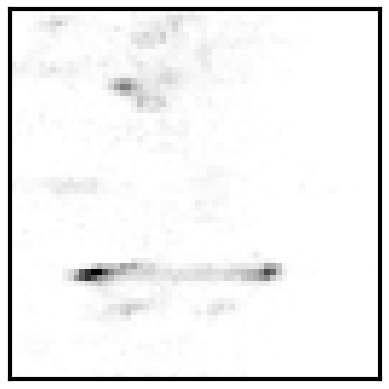

In [83]:
%autoreload 2
#from gettext import dpgettext
from pprint import pprint
%matplotlib inline
from peak_detection_2d.utils import plot_data_points_illustration

image, hint, label = dataset[9999]
logging.info("Is target: %s", label["target"])
to_plot = {
    "data": image[0].cpu(),
    #"hint_idx": hint.cpu(),
    #"mask": label["mask"][0].cpu(),
    #"hint_channel": (image[2].cpu())*100000,
}
logging.info("mask sum: %s", label["mask"][0].sum().item())

logging.info("hint channel sum: %s", image[2].sum().item())
plot_data_points_illustration(to_plot, zoom_in=False, label="hide", log_data=False)

row = maxquant_result_ref[maxquant_result_ref["mz_rank"] == label["pept_mz_rank"]]
if (True) and (not row["Decoy"].values[0]):
    logging.info("add label")
else:
    logging.info("no label since it is decoys")
pprint(
    row[
        [
            "source",
            "Decoy",
            "mz_rank",
            "MS1_frame_idx_left_exp",
            "MS1_frame_idx_right_exp",
            "MS1_frame_idx_left_ref",
            "MS1_frame_idx_center_ref",
            "MS1_frame_idx_right_ref",
            "IM_search_idx_left",
            "IM_search_idx_right",
            "IM_search_idx_center",
        
        ]
    ]
)
plt.savefig("/cmnfs/home/z.xiao/swaps_paper/figures/example_activation_raw.png", dpi=300, format = "png")

In [ ]:
import sparse

hint_matrix = sparse.load_npz(
    "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_exp_library_160ms_with_decoy_pred_20240812_160156_311148/peak_selection/training_data/hint_matrix.npz"
)
hint_matrix[493:545, 0:691, 10005].nonzero()

2024-08-16 17:19:35,529 - numba.core.entrypoints - DEBUG - Loading extension: EntryPoint(name='init', value='sparse._numba_extension:_init_extension', group='numba_extensions')
2024-08-16 17:19:35,983 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=398)
           2	LOAD_GLOBAL(arg=0, lineno=455)
           4	LOAD_ATTR(arg=1, lineno=455)
           6	LOAD_ATTR(arg=2, lineno=455)
           8	LOAD_METHOD(arg=3, lineno=455)
          10	LOAD_GLOBAL(arg=0, lineno=455)
          12	LOAD_ATTR(arg=4, lineno=455)
          14	LOAD_ATTR(arg=5, lineno=455)
          16	CALL_METHOD(arg=1, lineno=455)
          18	STORE_FAST(arg=2, lineno=455)
          20	LOAD_FAST(arg=2, lineno=456)
          22	LOAD_METHOD(arg=6, lineno=456)
          24	LOAD_CONST(arg=1, lineno=456)
          26	CALL_METHOD(arg=1, lineno=456)
          28	POP_TOP(arg=None, lineno=456)
          30	LOAD_GLOBAL(arg=0, lineno=457)
          32	LOAD_ATTR(arg=1, lineno=457)
          34	LOAD_ATTR(a

(array([25, 26]), array([ 50, 278]))

# Training

In [32]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

## Sanity check

In [6]:
from peak_detection_2d.model.seg_model import UNET

from torchinfo import summary

net = UNET(in_channels=3, first_out_channels=32, exit_channels=1, downhill=6, padding=1)

summary(
    model=net,
    # (batch_size, color_channels, height, width)
    input_size=(128, 3, 258, 258),  # shape =should be (multiple of 2^n_downhill)+2
    col_names=["input_size", "output_size", "num_params"],
    col_width=20,
    row_settings=["var_names"],
    depth=5,
)

/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-30 09:07:59,402 - torio._extension.utils - DEBUG - Loading FFmpeg6
2024-08-30 09:07:59,406 - torio._extension.utils - DEBUG - Failed to load FFmpeg6 extension.
Traceback (most recent call last):
  File "/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torio/_extension/utils.py", line 116, in _find_ffmpeg_extension
    ext = _find_versionsed_ffmpeg_extension(ffmpeg_ver)
  File "/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torio/_extension/utils.py", line 108, in _find_versionsed_ffmpeg_extension
    _load_lib(lib)
  File "/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torio/_extension/utils.py", line 94, in _load_lib
    torch.ops.load_library(path)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #
UNET (UNET)                                             [128, 3, 258, 258]   [128, 1, 258, 258]   --
├─Encoder (encoder)                                     [128, 3, 258, 258]   [128, 2048, 4, 4]    --
│    └─ModuleList (enc_layers)                          --                   --                   --
│    │    └─CNNBlocks (0)                               [128, 3, 258, 258]   [128, 32, 258, 258]  --
│    │    │    └─ModuleList (layers)                    --                   --                   9,280
│    │    │    │    └─CNNBlock (0)                      [128, 3, 258, 258]   [128, 32, 258, 258]  928
│    │    └─MaxPool2d (1)                               [128, 32, 258, 258]  [128, 32, 129, 129]  --
│    │    └─CNNBlocks (2)                               [128, 32, 129, 129]  [128, 64, 129, 129]  --
│    │    │    └─ModuleList (layers)                    --                   --   

## Train model

In [15]:
%autoreload 2
from peak_detection_2d.train import train

cfg_peak_selection = cfg.PEAK_SELECTION
cfg_peak_selection.TRAINING_DATA = [
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection/training_data/train_datapoints_TD_peptbatch0.hdf5",
    ),
    os.path.join(cfg.RESULT_PATH, "peak_selection/training_data/train_datapoints_TD_peptbatch1.hdf5"),
]
cfg_peak_selection.MODEL.SOLVER.TOTAL_EPOCHS = 5
cfg_peak_selection.MODEL.RESUME_PATH =""
cfg_peak_selection.CLSMODEL.RESUME_PATH = ""
cfg_peak_selection.CLSMODEL.KEEP_TRAINING = True
cfg_peak_selection.MODEL.KEEP_TRAINING = True
cfg_peak_selection.CLSMODEL.SOLVER.TOTAL_EPOCHS = 5
cfg_peak_selection.DATASET.TRAIN_BATCH_SIZE = 16
cfg_peak_selection.DATASET.VAL_BATCH_SIZE = 32
cfg_peak_selection.DATASET.TEST_BATCH_SIZE = 32
ps_exp_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", "test_cls_score")
if not os.path.exists(ps_exp_dir):
    os.mkdir(ps_exp_dir)
best_model_path = train(
    cfg_peak_selection,
    ps_exp_dir=ps_exp_dir,
    random_state=42,
    maxquant_dict=maxquant_result_ref,
)

2024-08-30 13:21:45,188 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f31729e5cf0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f31729e4c40>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f31729e4cd0>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f31729e4970>]
2024-08-30 13:21:45,189 - root - INFO - Dataset channels: 3
2024-08-30 13:21:45,204 - root - INFO - Use hint channel: True
2024-08-30 13:21:45,233 - root - INFO - Image shape in initial dataset: torch.Size([3, 258, 258])
2024-08-30 13:21:45,243 - root - INFO - Image shape in train_val_dataset: torch.Size([3, 258, 258])
2024-08-30 13:21:45,247 - root - INFO - Train dataset size: 9218
2024-08-30 13:21:45,248 - root - INFO - Train eval dataset size: 1844
2024-08-30 13:21:45,248 - root - INFO - Validation dataset size: 1025
2024-08-30 13:21:45,249 - root - INFO - Test dataset size: 1139
2024-08-

KeyboardInterrupt: 

In [8]:
test_pred_df = pd.read_csv(
    os.path.join(
        cfg.RESULT_PATH,
        "peak_selection",
        "test_cls_score",
        "results",
        "test_pred_df.csv",
    )
)
from peak_detection_2d.utils import calc_fdr_and_thres

test_pred_df_new = calc_fdr_and_thres(
    test_pred_df, filter_dict={"log_sum_intensity": [2, 100]}, return_plot=True
)

In [14]:
from peak_detection_2d.infer_on_pept_act import infer_on_pept_act

cfg.PEAK_SELECTION = cfg_peak_selection
cfg.OPTIMIZATION.N_BLOCKS_BY_PEPT = 1
cfg.PEAK_SELECTION.DATASET.INFER_BATCH_SIZE = 32
infer_on_pept_act(
    cfg=cfg,
    best_seg_model_path=cfg_peak_selection.MODEL.RESUME_PATH,
    best_cls_model_path=cfg_peak_selection.CLSMODEL.RESUME_PATH,
    maxquant_dict=maxquant_result_ref,
    ps_exp_dir=ps_exp_dir,
)

2024-08-30 13:11:28,184 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f318c346e30>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f318c3472e0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f318c347d90>, <peak_detection_2d.dataset.dataset.Mask_MinMaxScale object at 0x7f318c346950>]
2024-08-30 13:11:28,685 - peak_detection_2d.infer_on_pept_act - INFO - best_seg_model_path: /cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/120min_libaray_100ms_20240826_175342_706954/peak_selection/test_cls_score/model_backups/bst_seg_model_0.5762.pt
2024-08-30 13:11:29,040 - peak_detection_2d.infer_on_pept_act - INFO - Infering on pept batch 0 ...
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/dataset/dataset.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

KeyboardInterrupt: 

# Evaluation

In [7]:
result_dir = os.path.join(
    cfg.RESULT_PATH, "peak_selection", "test_multi_output", "results"
)
test_pred_df = pd.read_csv(
    os.path.join(
        result_dir,
        "test_pred_df.csv",
    )
)

In [25]:
%autoreload 2
from peak_detection_2d.utils import plot_target_decoy_distr

plot_target_decoy_distr(test_pred_df, save_dir=result_dir, dataset_name = "testset", threshold=(0.2, 2))

2024-08-16 18:19:00,941 - root - INFO - target decoy counts: False    16
True      6
Name: Decoy, dtype: int64


In [20]:
%autoreload 2
from peak_detection_2d.infer_on_pept_act import infer_on_pept_act

ps_exp_dir = os.path.join(cfg.RESULT_PATH, "peak_selection", "test_multi_output")
best_model_path =os.path.join(cfg.RESULT_PATH, "peak_selection", "test_multi_output","model_backups", "bst_model_1.0524.pt")
maxquant_result_ref_sample = maxquant_result_ref.sample(1000, replace=False)
cfg.PEAK_SELECTION.DATASET.INFER_BATCH_SIZE = 32
infer_on_pept_act(
    cfg=cfg,
    best_model_path=best_model_path,
    maxquant_dict=maxquant_result_ref_sample,
    ps_exp_dir=ps_exp_dir,
)

2024-08-16 18:14:36,306 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f255f5ac6a0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f255f5ac6d0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f255f5ad150>]
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/dataset/dataset.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxquant_dict[
2024-08-16 18:14:57,782 - peak_detection_2d.dataset.dataset - DEBUG - Creating data index [37456 30149 30437 29024 32848 41803 22889 23835 35550 17465 43315 43580
   925 26664 15115 19198  6124 33957  3979 31948 20015 38070  7099 36995
 41367 11455 30950 40349 13436 39323 39472 376

In [22]:
pept_act_sum_ps = pd.read_csv(os.path.join(ps_exp_dir, "pept_act_sum_ps.csv"))

<Axes: xlabel='target_decoy_score', ylabel='Density'>

0.7153228612914452

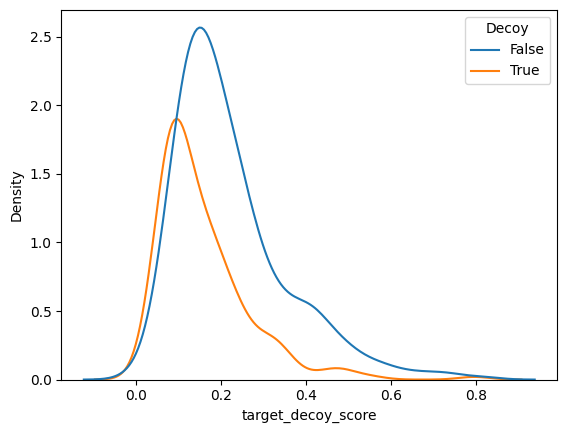

In [23]:
pept_act_sum_pd_full = pd.merge(
    left=pept_act_sum_ps,
    right=maxquant_result_ref[["Decoy", "mz_rank"]],
    on="mz_rank",
    how="left",
)
import seaborn as sns
from sklearn.metrics import roc_auc_score

pept_act_sum_pd_full["log_sum_intensity"] = np.log10(
    pept_act_sum_pd_full["sum_intensity"] + 1
)
pept_act_sum_pd_full["out_score_scaled"] = (
    pept_act_sum_pd_full["out_score"] - pept_act_sum_pd_full["out_score"].min()
) / (pept_act_sum_pd_full["out_score"].max() - pept_act_sum_pd_full["out_score"].min())
sns.kdeplot(
    # data=test_pred_df.loc[test_pred_df["log_sum_intensity"] > -10],
    data=pept_act_sum_pd_full.loc[pept_act_sum_pd_full["log_sum_intensity"] >= 2.5],
    x="target_decoy_score",
    hue="Decoy",
    common_norm=True,
)
roc_auc_score(
    y_true=1 - pept_act_sum_pd_full["Decoy"],
    y_score=pept_act_sum_pd_full["target_decoy_score"],
)

In [29]:
plot_target_decoy_distr(
    pept_act_sum_pd_full,
    save_dir=result_dir,
    dataset_name="fullset",
    threshold=(0.1, 1),
)

2024-08-16 18:20:52,657 - root - INFO - target decoy counts: False    353
True     153
Name: Decoy, dtype: int64


<Axes: xlabel='log_sum_intensity', ylabel='target_decoy_score'>

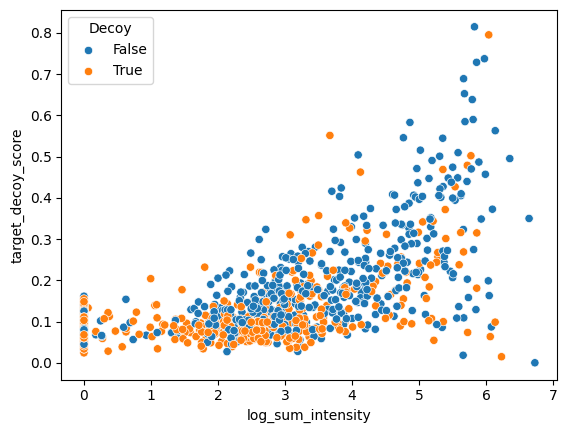

In [24]:
sns.scatterplot(
    data=pept_act_sum_pd_full,
    x="log_sum_intensity",
    y="target_decoy_score",
    hue="Decoy",
)

In [ ]:
test_pred_df = pd.read_csv(
    cfg.RESULT_PATH + "/peak_selection/test_multi_output/results/test_pred_df.csv"
)
test_pred_df_full = pd.merge(
    left=test_pred_df,
    right=maxquant_result_ref[["mz_rank", "Decoy"]],
    on="mz_rank",
    how="left",
)

<Axes: xlabel='target_decoy_score', ylabel='Density'>

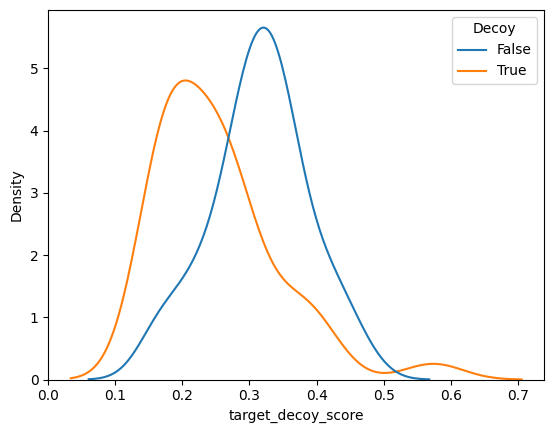

In [ ]:
import seaborn as sns

test_pred_df["log_sum_intensity"] = np.log10(test_pred_df["sum_intensity"] + 1)
test_pred_df["out_score_scaled"] = (
    test_pred_df["out_score"] - test_pred_df["out_score"].min()
) / (test_pred_df["out_score"].max() - test_pred_df["out_score"].min())
sns.kdeplot(
    # data=test_pred_df.loc[test_pred_df["log_sum_intensity"] > -10],
    data=test_pred_df,
    x="target_decoy_score",
    hue="Decoy",
    common_norm=False,
)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(
    y_true=1 - test_pred_df["Decoy"], y_score=test_pred_df["target_decoy_score"]
)

0.7433862433862433

# Predict on unprocessed sparse matrix

In [ ]:
# prepare data
import sparse

swaps_dir = "/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_120min_library_80ms_with_decoy_pred_20240806_090347_182738/"

exp_dir = os.path.join(swaps_dir, "peak_selection", "exp_20240808_210454_905643")

act_3d = sparse.load_npz(
    os.path.join(
        swaps_dir, "results", "activation", "im_rt_pept_act_coo_peptbatch0.npz"
    )
)
hint_matrix = sparse.load_npz(
    os.path.join(swaps_dir, "peak_selection", "training_data/hint_matrix.npz")
)

In [ ]:
from utils.config import get_cfg_defaults
from utils.singleton_swaps_optimization import swaps_optimization_cfg

ps_config_path = os.path.join(exp_dir, "updated_peak_selection_config.yaml")
cfg_peak_selection = get_cfg_defaults(swaps_optimization_cfg.PEAK_SELECTION)
cfg_peak_selection.merge_from_file(ps_config_path)

In [ ]:
pept_batch_size = act_3d.shape[2] // 4
maxquant_result_ref["pept_batch_idx"] = (
    maxquant_result_ref["mz_rank"] // pept_batch_size
).astype(int)
max_pept_batch_idx = maxquant_result_ref["pept_batch_idx"].max()
maxquant_result_ref.loc[
    maxquant_result_ref["pept_batch_idx"] == max_pept_batch_idx, "pept_batch_idx"
] = (max_pept_batch_idx - 1)

In [ ]:
batch0_maxquant_ref = maxquant_result_ref.loc[
    maxquant_result_ref["pept_batch_idx"] == 0
]
sample_batch0_maxquant_ref = batch0_maxquant_ref.sample(n=4000, replace=False)

In [ ]:
%autoreload 2
from peak_detection_2d.dataset.dataset import (
    PeptActPeakSelection_Infer_Dataset,
    build_transformation,
)
from peak_detection_2d.model.build_model import build_model
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_model(cfg_peak_selection.MODEL)
checkpoint = torch.load(
    os.path.join(exp_dir, "model_backups", "bst_model_0.5104.pt"), map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
transformation, _ = build_transformation(cfg_peak_selection.DATASET)
infer_dataset = PeptActPeakSelection_Infer_Dataset(
    pept_act_coo_peptbatch=act_3d,
    maxquant_dict=sample_batch0_maxquant_ref,
    hint_matrix=hint_matrix,
    transforms=transformation,
    use_hint_channel=True,
)
# feed into modle
# generate a pept_act_sun.csv

<All keys matched successfully>

2024-08-09 09:44:44,922 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f7bdac78520>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f7a974ae2c0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f7a974ace50>]


In [ ]:
torch.cuda.empty_cache()
import gc

gc.collect()

31

In [ ]:
# Example usage
infer_dataset = PeptActPeakSelection_Infer_Dataset(
    pept_act_coo_peptbatch=act_3d,
    maxquant_dict=sample_batch0_maxquant_ref,
    hint_matrix=hint_matrix,
    transforms=transformation,
    use_hint_channel=True,
)
infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset, batch_size=32, shuffle=False
)
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

result = inference_and_sum_intensity(
    seg_model=model, data_loader=infer_dataloader, device=device, calc_score=True
)

2024-08-09 09:44:55,258 - numba.core.entrypoints - DEBUG - Loading extension: EntryPoint(name='init', value='sparse._numba_extension:_init_extension', group='numba_extensions')
2024-08-09 09:44:55,506 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=398)
           2	LOAD_GLOBAL(arg=0, lineno=455)
           4	LOAD_ATTR(arg=1, lineno=455)
           6	LOAD_ATTR(arg=2, lineno=455)
           8	LOAD_METHOD(arg=3, lineno=455)
          10	LOAD_GLOBAL(arg=0, lineno=455)
          12	LOAD_ATTR(arg=4, lineno=455)
          14	LOAD_ATTR(arg=5, lineno=455)
          16	CALL_METHOD(arg=1, lineno=455)
          18	STORE_FAST(arg=2, lineno=455)
          20	LOAD_FAST(arg=2, lineno=456)
          22	LOAD_METHOD(arg=6, lineno=456)
          24	LOAD_CONST(arg=1, lineno=456)
          26	CALL_METHOD(arg=1, lineno=456)
          28	POP_TOP(arg=None, lineno=456)
          30	LOAD_GLOBAL(arg=0, lineno=457)
          32	LOAD_ATTR(arg=1, lineno=457)
          34	LOAD_ATTR(a

In [ ]:
infer_result = pd.merge(
    result,
    maxquant_result_ref,
    how="left",
    left_on="mz_rank",
    right_on="mz_rank",
    suffixes=("_ref", "_pred"),
)

In [ ]:
decoy_mzbin = maxquant_result_ref.loc[maxquant_result_ref["Decoy"], "mz_bin"].unique()
random_sample = np.random.choice(decoy_mzbin, size=10, replace=False)

In [ ]:
in_mz_bins = maxquant_result_ref.loc[maxquant_result_ref["mz_bin"].isin(random_sample)]

In [ ]:
in_mz_bins[["mz_bin", "Decoy"]].value_counts()

mz_bin   Decoy
977.01   True     5
969.84   True     3
977.01   False    3
1063.20  True     2
1213.13  True     2
751.61   False    1
         True     1
792.08   True     1
817.80   True     1
891.69   False    1
         True     1
1072.58  True     1
1162.55  True     1
1213.13  False    1
dtype: int64

In [ ]:
infer_result["Decoy"].value_counts()

True     2375
False    1624
Name: Decoy, dtype: int64

<Axes: xlabel='log_sum_intensity', ylabel='Density'>

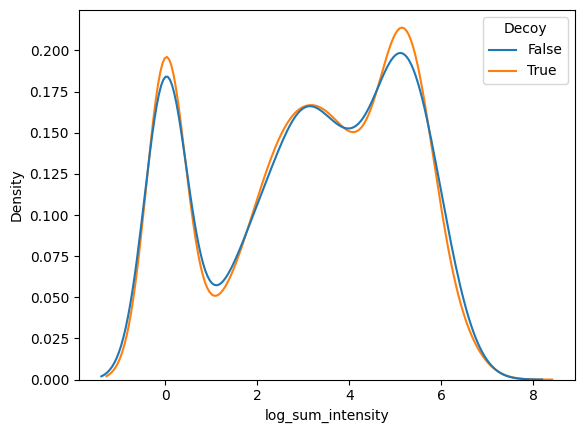

In [ ]:
import seaborn as sns

infer_result["log_sum_intensity"] = np.log10(infer_result["sum_intensity"] + 1)
sns.kdeplot(data=infer_result, x="log_sum_intensity", hue="Decoy", common_norm=False)

In [ ]:
dp_dict = infer_dataset[286]

In [ ]:
output = model(
    dp_dict[0].float().unsqueeze(0).to(device),
)

tensor(0., dtype=torch.float64)

tensor(4., device='cuda:0', dtype=torch.float64)

2024-08-09 10:16:45,749 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


119

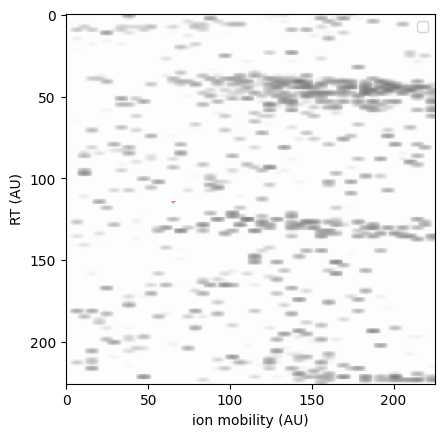

In [ ]:
from peak_detection_2d.utils import plot_data_points

image, hint, label = infer_dataset[119]
to_plot = {
    "data": image[0].cpu(),
    "hint_idx": hint.cpu(),
    "mask": label["mask"][0].cpu(),
    "hint_channel": image[2].cpu(),
}
label["mask"][0].sum()
image[2].sum()
plot_data_points(
    to_plot,
    zoom_in=False,
    label="mask",
    log_data=True,
    # pred_mask=output[0].cpu().detach().numpy()[0],
)
label["pept_mz_rank"]

In [ ]:
image[2].sum()

tensor(1., device='cuda:0', dtype=torch.float64)

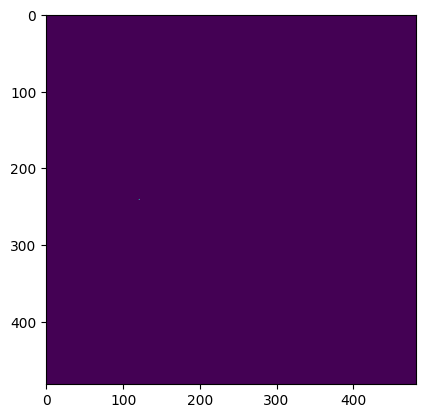

In [ ]:
plt.imshow(image[2].cpu())

In [ ]:
# Example usage

infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset, batch_size=32, shuffle=False
)
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

result = inference_and_sum_intensity(
    seg_model=model, data_loader=infer_dataloader, device=device
)

2024-08-08 11:35:23,385 - peak_detection_2d.dataset.dataset - WARNING - No maxquant result found for peptide mz rank 0
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 5.93 GiB. GPU  (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
2024-08-08 11:35:27,189 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 481
2024-08-08 11:35:27,191 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (32,)
2024-08-08 11:35:27,195 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (32,)
/cmnfs/home/z.xiao/miniconda3/envs/sbs/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 2.97 GiB. GPU  (Trigg

SystemError: CPUDispatcher(<function _compute_mask at 0x7f454cacc1f0>) returned a result with an exception set

## Eval on test

In [ ]:
from peak_detection_2d.train import testset_eval
from peak_detection_2d.dataset.dataset import (
    MultiHDF5_MaskDataset,
    build_transformation,
)

hdf5_files = cfg_peak_selection.TRAINING_DATA
transformation, _ = build_transformation(cfg_peak_selection.DATASET)
use_hint_channel = "hint" in cfg_peak_selection.DATASET.INPUT_CHANNELS
dataset = MultiHDF5_MaskDataset(
    hdf5_files,
    use_hint_channel=use_hint_channel,
    transforms=transformation,
)
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=cfg_peak_selection.DATASET.TRAIN_VAL_SIZE,
    seed=42,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

2024-08-08 11:49:42.209855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 11:49:52,178 - tensorflow - DEBUG - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2024-08-08 11:49:53.659302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-08 11:50:10,701 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Padding object at 0x7f44712d52a0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f44712d6aa0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f44712d6980>]


In [ ]:
%autoreload 2
from result_analysis.result_analysis import SBSResult
import pandas as pd
try:
    test_pred_df = pd.read_csv(
        os.path.join(exp_dir, "results", "test_pred_df.csv")
    )
except FileNotFoundError:
    test_pred_df = inference_and_sum_intensity(
        data_loader=test_dataloader,
        seg_model=model,
        device=device,
        calc_score = True,
        # calc_score="sigmoid",
        # plot_calib_score_distribution=True,
        # result_dir=os.path.join(exp_dir, "results"),
    )
    test_pred_df.to_csv(
        os.path.join(exp_dir, "results", "test_pred_df.csv"), index=False
    )
# maxquant_merge = pd.read_pickle(
#     os.path.join(result_dir, "maxquant_result_ref.pkl")
# )


2024-08-08 12:23:43,328 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 481
2024-08-08 12:23:43,330 - peak_detection_2d.model.seg_model - DEBUG - valid_pixel shape torch.Size([32, 232324])
2024-08-08 12:23:43,355 - peak_detection_2d.model.seg_model - DEBUG - out_score shape (32,)
2024-08-08 12:23:43,357 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (32,)
2024-08-08 12:23:43,360 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (32,)
2024-08-08 12:23:44,457 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 481
2024-08-08 12:23:44,459 - peak_detection_2d.model.seg_model - DEBUG - valid_pixel shape torch.Size([32, 232324])
2024-08-08 12:23:44,461 - peak_detection_2d.model.seg_model - DEBUG - out_score shape (64,)
2024-08-08 12:23:44,462 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (64,)
2024-08-08 12:23:44,466 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity 

TypeError: SBSResult.__init__() got an unexpected keyword argument 'sum_raw'

In [ ]:
test_pred_df.rename(columns={"pept_mz_rank": "mz_rank"}, inplace=True)

2024-08-08 12:30:05,411 - result_analysis.result_analysis - DEBUG - Pept activation sum columns: Index(['sum_intensity', 'mz_rank', 'out_score'], dtype='object')
2024-08-08 12:30:05,415 - result_analysis.result_analysis - INFO - Reference shape: (179460, 119)
2024-08-08 12:30:05,510 - result_analysis.result_analysis - DEBUG - Reference shape after merging activation sum: (3458, 121)
2024-08-08 12:30:05,511 - result_analysis.result_analysis - DEBUG - Ref df mz_rank columns: (3458,)
2024-08-08 12:30:05,518 - result_analysis.result_analysis - DEBUG - sum cols: ['sum_intensity', 'mz_rank', 'out_score']
2024-08-08 12:30:05,518 - result_analysis.result_analysis - DEBUG - Reference non zero shape: (3418, 121)
2024-08-08 12:30:05,521 - result_analysis.result_analysis - INFO - No grouping, show precurosr level correlation
2024-08-08 12:30:05,521 - result_analysis.result_analysis - DEBUG - Ref exp inner shape (3458, 121)


Data:  Intensity_log sum_intensity_log , slope =  0.978 , intercept =  -0.497 , PearsonR =  0.756 , SpearmanR =  0.812


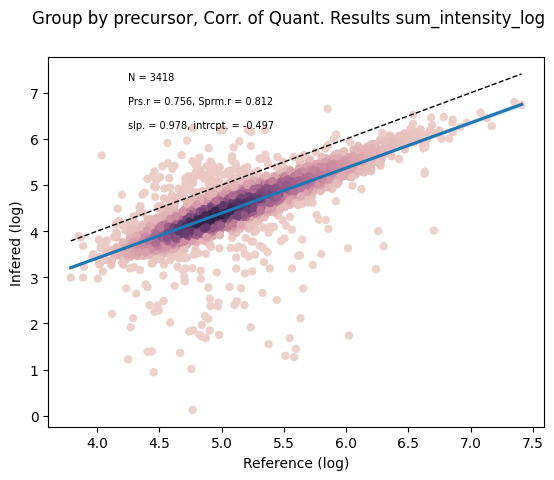

In [ ]:
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_result_ref,
    maxquant_merge_df=maxquant_result_ref,
    pept_act_sum_df_list=[test_pred_df],
    # sum_raw=test_pred_df,
    # sum_gaussian=train_label_df,
    ims=True,
    # other_cols=other_cols
)
sbs_ims_result.plot_intensity_corr(
    ref_col="Intensity",
    inf_col="sum_intensity",
    contour=False,
    # group_by="Leading razor protein",
    # save_dir=os.path.join(peak_selection_dir, "results"),
)

In [ ]:
testset_eval(
    best_seg_model_path="/cmnfs/proj/ORIGINS/SWAPS_exp/tims_ramp_time/corrected_RT_tol_pred_120min_library_80ms_with_decoy_pred_20240806_090347_182738/peak_selection/exp_20240807_145220_847593/model_backups/bst_model_0.7929.pt",
    cfg_seg_model=cfg_peak_selection.MODEL,
    test_dataset=test_dataset,
    test_dataloader=test_dataloader,
    result_dir=exp_dir,
    device=device,
    exp=cfg_peak_selection.DATASET.ONLY_LOG_CHANNEL,
    threshold=cfg_peak_selection.MODEL.EVALUATION.THRESHOLD,
)

In [ ]:
pept_batch_size = act_3d.shape[2] // 4
maxquant_result_ref["pept_batch_idx"] = (
    maxquant_result_ref["mz_rank"] // pept_batch_size
).astype(int)
max_min_mz_rank = maxquant_result_ref.groupby("pept_batch_idx")["mz_rank"].agg(
    ["min", "max"]
)
cutoff = [0]
cutoff.extend(max_min_mz_rank["min"].values[1:-1].tolist())
cutoff.append(max_min_mz_rank["max"].values[-1] + 1)
cutoff

[0, 44865, 89730, 134595, 179461]

In [ ]:
%autoreload 2
from peak_detection_2d.dataset.dataset import (
    PeptActPeakSelection_Infer_Dataset,
    build_transformation,
)
from peak_detection_2d.model.build_model import build_model
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = build_model(cfg_peak_selection.MODEL)
checkpoint = torch.load(
    os.path.join(exp_dir, "model_backups", "bst_model_0.7929.pt"), map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
transformation, _ = build_transformation(cfg_peak_selection.DATASET)
infer_dataset = PeptActPeakSelection_Infer_Dataset(
    pept_act_coo_peptbatch=act_3d,
    maxquant_dict=maxquant_result_ref.loc[maxquant_result_ref["pept_batch_idx"] == 0],
    hint_matrix=hint_matrix,
    transforms=transformation,
    use_hint_channel=True,
)
# feed into modle
# generate a pept_act_sun.csv

<All keys matched successfully>

2024-08-07 15:12:56,453 - peak_detection_2d.dataset.dataset - INFO - Transformation: [<peak_detection_2d.dataset.dataset.Mask_Resize object at 0x7f8a49d6f7c0>, <peak_detection_2d.dataset.dataset.Mask_AddLogChannel object at 0x7f8a43d9bbb0>, <peak_detection_2d.dataset.dataset.Mask_AddHintChannel object at 0x7f8a43d99de0>]
/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/dataset/dataset.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxquant_dict[


In [ ]:
# Example usage

infer_dataloader = torch.utils.data.DataLoader(
    infer_dataset, batch_size=16, shuffle=False
)
from peak_detection_2d.model.seg_model import inference_and_sum_intensity

result = inference_and_sum_intensity(
    seg_model=model, data_loader=infer_dataloader, device=device
)

2024-08-07 15:13:08,944 - peak_detection_2d.dataset.dataset - WARNING - No maxquant result found for peptide mz rank 0
2024-08-07 15:13:10,762 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 193
2024-08-07 15:13:10,764 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (16,)
2024-08-07 15:13:10,765 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (16,)
2024-08-07 15:13:11,492 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 193
2024-08-07 15:13:11,493 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (32,)
2024-08-07 15:13:11,494 - peak_detection_2d.model.seg_model - DEBUG - sum_intensity shape (32,)
2024-08-07 15:13:12,245 - peak_detection_2d.model.seg_model - DEBUG - out non zero value distribution: 0, 193
2024-08-07 15:13:12,247 - peak_detection_2d.model.seg_model - DEBUG - pept_mz_rank shape (48,)
2024-08-07 15:13:12,248 - peak_detection_2d.model.seg_model - DEBUG - sum_

SystemError: CPUDispatcher(<function _compute_mask at 0x7f8d76db9f30>) returned a result with an exception set